# Method Verification

In this script, the probabilities from the MCWF method is compared against the probabilities from a density matrix simulation to validate the MCWF method as a valid implementation for noisy statevector simulations.

## Import Libraries

In [1]:
from NoisyCircuits import QuantumCircuit as QC
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json

2026-02-17 17:28:31,550	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Initialize the Noise Model

In [2]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum token
backend_name = "ibm_fez"
qpu_type = "heron"
verbose = False

Run the code below to use the latest noise model from IBM hardware calibration data

In [3]:
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()

qiskit_runtime_service._discover_account:WARNING:2026-02-17 17:28:33,595: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-02-17 17:28:36,571: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-17 17:28:36,576: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-17 17:28:36,919: Using instance: Open_Sys, plan: open


Run the code below in case API access is not feasible, and use the sample noise model provided with the software

In [3]:
if qpu_type == "heron":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb"))
elif qpu_type == "eagle":
    noise_model = pickle.load(open("../noise_models/Noise_Model_Eagle_QPU.pkl", "rb"))
else:
    raise ValueError("Unsupported QPU type. Supported types are 'heron' and 'eagle'.")

## Define the Randomized Circuit

Define the function that can generate a randomized circuit that can be executed using density matrix simulation and as an MCWF execution.

In [4]:
def build_random_circuit(circuit, depth, num_qubits):
    circuit.refresh()
    gate = {
        "X" : circuit.X,
        "SX": circuit.SX,
    }
    for _ in range(depth):
        for i in range(num_qubits):
            choice = np.random.choice(["X", "SX"])
            gate[choice](i)
        for i in range(num_qubits-1):
            circuit.CZ(i, i+1)

## Define the Metrics

Define the function that can compute the desired validation metrics between the reference probability distribution (from the density matrix) and the probability distribution from the MCWF method. The chosen metrics are:

1. **Battacharyya Coefficient:** Defines the overlap between two probability distributions and is bounded between $[0,1]$, where a value of $1$ indicates a similar distributions. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
BC(p,q) = \sum_{i=1}^{N} \sqrt{p_iq_i}
\end{equation*}
Interpretation: The closer the two distributions are in similarity, the closer value of the Battacharyya Coefficient is to $1$.

2. **Battacharyya Distance:** Provides a distance measure that indicates the dissimilarity between two probability distributions and lies between $[0, \infty]$, where a value of $0$ indicates a similar distribution and higher the value, the greater the dissimilarity between the two distributions. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
BD(p,q) = -\text{log}(BC(p,q))
\end{equation*}

3. **Hellinger Distance:** Provides a measure of the geometric difference between two probability distributions and is bounded between $[0,1]$, where a value of $0$ indicates a similar distribution. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
HD(p,q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^{N}(\sqrt{p_i} - \sqrt{q_i})^2}
\end{equation*}

4. **Jenson-Shannon (JS) Divergence:** It is the smoothed, symmetric version of the KL divergence, measuring the average information divergence between the two distributions and is bounded between $[0, \text{log}(2)]$ where lower the value the lesser the information loss. The value for two discrete distributions can be computed using the equation below.
\begin{equation*}
JSD(p||q) = \frac{1}{2}(KL(p||m) + KL(q||m)) \text{ with } m = \frac{p+q}{2}
\end{equation*}

\begin{equation*}
KL(a||b) = \sum_{i=1}^{N}a_i\text{log}(\frac{a_i}{b_i})
\end{equation*}

In [5]:
def compute_metrics(pd_1, pd_2):
    battacharyya_coefficient = np.sum(np.sqrt(pd_1 * pd_2))
    battacharyya_distance = -np.log(battacharyya_coefficient)
    hellinger_distance = np.sqrt(np.sum((np.sqrt(pd_1) - np.sqrt(pd_2))**2)) / np.sqrt(2)
    m = 0.5 * (pd_1 + pd_2)
    js = 0.5 * np.sum(pd_1 * np.log(1e-10 + pd_1 / m) + pd_2 * np.log(1e-10 + pd_2 / m))
    return (battacharyya_coefficient, battacharyya_distance, hellinger_distance, js)

## Define Randomized Test Parameters

Define the range for the number of qubits to use and the total number of single qubit gates per qubit. Note that an entanglement gate is applied to after each single qubit gate (recommended to start with 2 qubits).

In [6]:
qubit_list = [2, 3, 4, 5, 6, 7]
depth_list = [5, 20, 50, 100]

In [7]:
metrics_identifier = ("Battacharyya Coefficient", "Battacharyya Distance", "Hellinger Distance", "Jensen-Shannon Divergence")

def plot_metrics(dict_list, trajectory_list):
    depths = depth_list
    qubits = qubit_list
    
    for depth in depths:
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        for i, metric in enumerate(metrics_identifier):
            for traj_idx, traj_count in enumerate(trajectory_list):
                metric_values = []
                for num_qubits in qubits:
                    key = (num_qubits, depth)
                    if key in dict_list[traj_idx]:
                        metric_values.append(dict_list[traj_idx][key][metric])
                    else:
                        metric_values.append(0)
                ax[i//2, i%2].plot(qubits, metric_values, label=f"Trajectories: {traj_count}", marker='o')
            
            ax[i//2, i%2].set_title(f"{metric}")
            ax[i//2, i%2].set_xlabel("Number of Qubits")
            ax[i//2, i%2].set_xticks(qubits)
            ax[i//2, i%2].set_ylabel(metric)
            ax[i//2, i%2].legend()
            ax[i//2, i%2].grid()
        plt.suptitle(f"Comparison for Depth={depth}", fontsize=16)   
        plt.tight_layout()
        plt.show()

In [8]:
def run_experiment(sim_backend):
    mcwf_10t_results = {}
    mcwf_100t_results = {}
    mcwf_200t_results = {}
    mcwf_500t_results = {}
    mcwf_1000t_results = {}
    log = open("Results_Log_File_{}.log".format(sim_backend), "w")
    for num_qubits in qubit_list:
        circ = QC(num_qubits=num_qubits, 
                noise_model=noise_model,
                backend_qpu_type=qpu_type, 
                num_trajectories=1, 
                sim_backend = sim_backend,
                num_cores=50, 
                threshold=1e-8, 
                jsonize=True,
                verbose=verbose)
        for depth in depth_list:
            circ.refresh()
            log.write("===========================================================================\n")
            log.write(f"Running Circuit with {num_qubits} qubits and depth {depth}\n")
            build_random_circuit(circ, depth, num_qubits)
            probs_density_matrix = circ.run_with_density_matrix(list(range(num_qubits)))
            probs_mcwf_10t = circ.execute(list(range(num_qubits)), num_trajectories=10)
            probs_mcwf_100t = circ.execute(list(range(num_qubits)), num_trajectories=100)
            probs_mcwf_200t = circ.execute(list(range(num_qubits)), num_trajectories=200)
            probs_mcwf_500t = circ.execute(list(range(num_qubits)), num_trajectories=500)
            probs_mcwf_1000t = circ.execute(list(range(num_qubits)), num_trajectories=1000)
            metrics_10t = compute_metrics(probs_density_matrix, probs_mcwf_10t)
            metrics_100t = compute_metrics(probs_density_matrix, probs_mcwf_100t)
            metrics_200t = compute_metrics(probs_density_matrix, probs_mcwf_200t)
            metrics_500t = compute_metrics(probs_density_matrix, probs_mcwf_500t)
            metrics_1000t = compute_metrics(probs_density_matrix, probs_mcwf_1000t)
            key = (num_qubits, depth)
            mcwf_10t_results[key] = dict(
                [("num_qubits", num_qubits), ("depth", depth)] +
                [(metric, metrics_10t[i]) for i, metric in enumerate(metrics_identifier)]
            )
            mcwf_100t_results[key] = dict(
                [("num_qubits", num_qubits), ("depth", depth)] +
                [(metric, metrics_100t[i]) for i, metric in enumerate(metrics_identifier)]
            )
            mcwf_200t_results[key] = dict(
                [("num_qubits", num_qubits), ("depth", depth)] +
                [(metric, metrics_200t[i]) for i, metric in enumerate(metrics_identifier)]
            )
            mcwf_500t_results[key] = dict(
                [("num_qubits", num_qubits), ("depth", depth)] +
                [(metric, metrics_500t[i]) for i, metric in enumerate(metrics_identifier)]
            )
            mcwf_1000t_results[key] = dict(
                [("num_qubits", num_qubits), ("depth", depth)] +
                [(metric, metrics_1000t[i]) for i, metric in enumerate(metrics_identifier)]
            )
            log.write(f"Metrics for MCWF with {10} Trajectories:\n")
            for i in range(len(metrics_identifier)):
                log.write(f"{metrics_identifier[i]}: {metrics_10t[i]}\n")
            log.write(f"Metrics for MCWF with {100} Trajectories:\n")
            for i in range(len(metrics_identifier)):
                log.write(f"{metrics_identifier[i]}: {metrics_100t[i]}\n")
            log.write(f"Metrics for MCWF with {200} Trajectories:\n")
            for i in range(len(metrics_identifier)):
                log.write(f"{metrics_identifier[i]}: {metrics_200t[i]}\n")
            log.write(f"Metrics for MCWF with {500} Trajectories:\n")
            for i in range(len(metrics_identifier)):
                log.write(f"{metrics_identifier[i]}: {metrics_500t[i]}\n")
            log.write(f"Metrics for MCWF with {1000} Trajectories:\n")
            for i in range(len(metrics_identifier)):
                log.write(f"{metrics_identifier[i]}: {metrics_1000t[i]}\n")
            log.write("===========================================================================\n\n")
            log.flush()
        circ.shutdown()
    return mcwf_10t_results, mcwf_100t_results, mcwf_200t_results, mcwf_500t_results, mcwf_1000t_results

## Perform the Verification with the Randomized Circuits for Various Backends

### Backend - Qiskit

Successfully switched backend to qiskit.


2026-02-17 17:30:11,846	INFO worker.py:2007 -- Started a local Ray instance.
/Users/adam-ukj7r05xnu2fywx/miniconda3/envs/NoisyCircuits/lib/python3.10/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
[2026-02-17 17:30:42,524 E 696070 697164] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qiskit.


2026-02-17 17:32:06,552	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 17:32:37,185 E 696070 701480] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qiskit.


2026-02-17 17:35:51,234	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 17:36:21,877 E 696070 706160] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qiskit.


2026-02-17 17:41:04,628	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 17:41:35,267 E 696070 711197] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qiskit.


2026-02-17 17:48:07,422	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 17:48:38,077 E 696070 717084] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qiskit.


2026-02-17 17:56:06,051	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 17:56:36,704 E 696070 723067] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


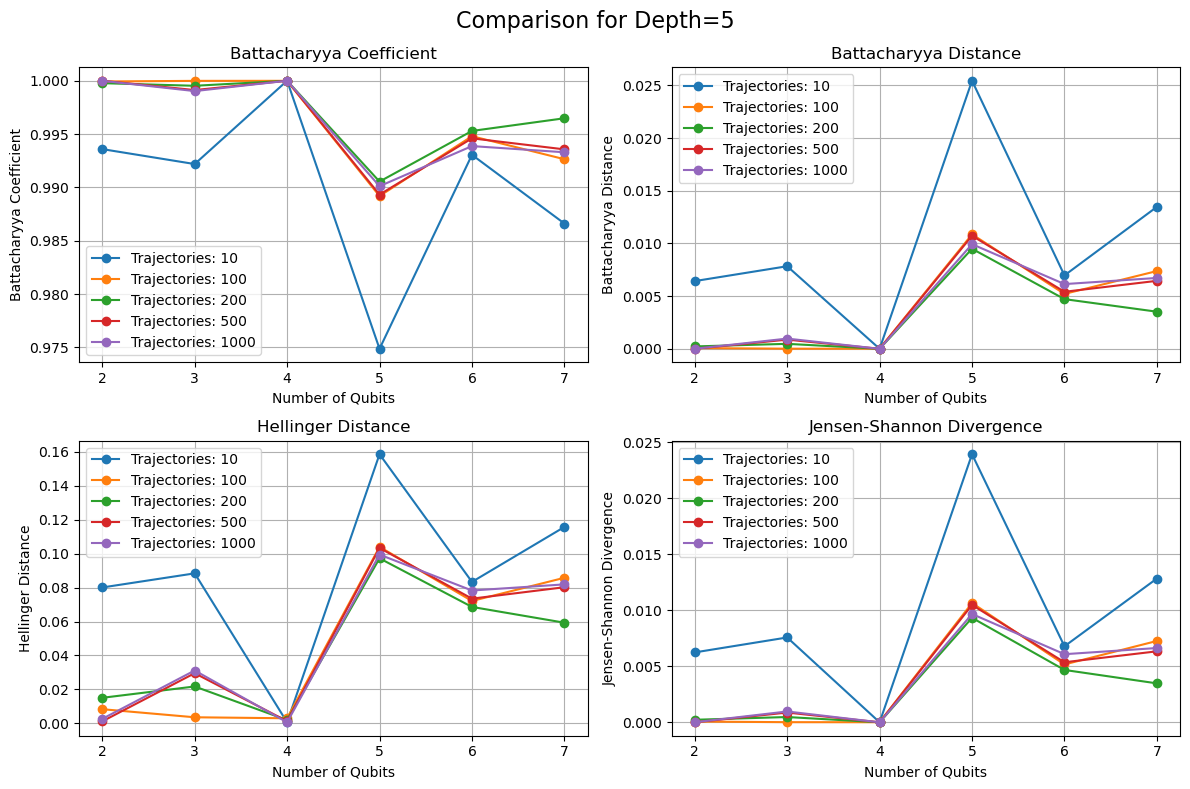

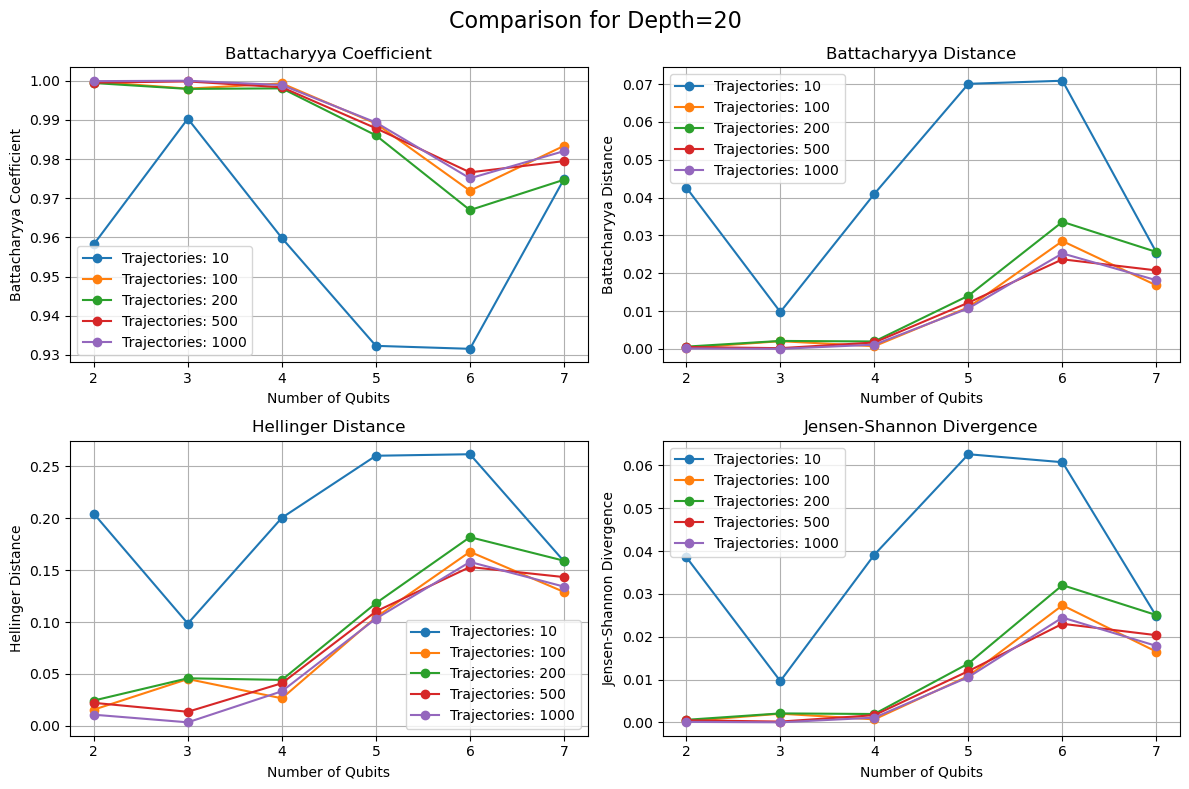

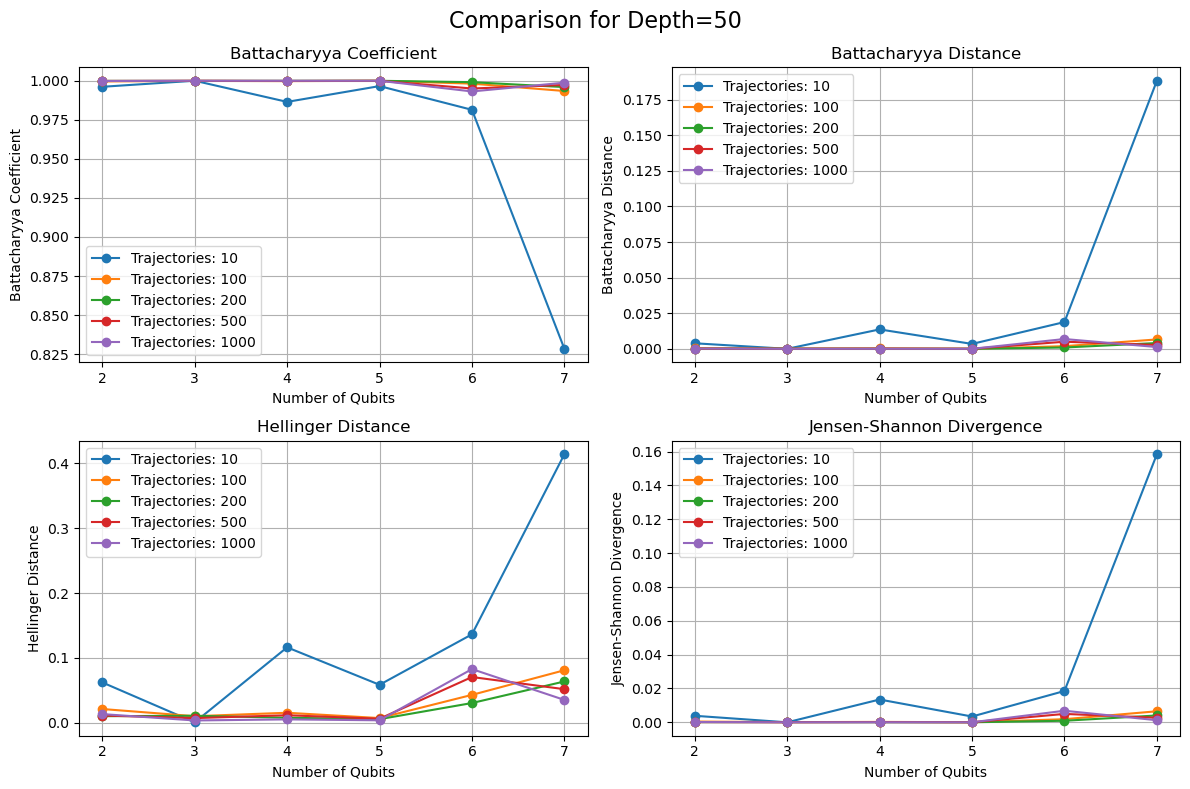

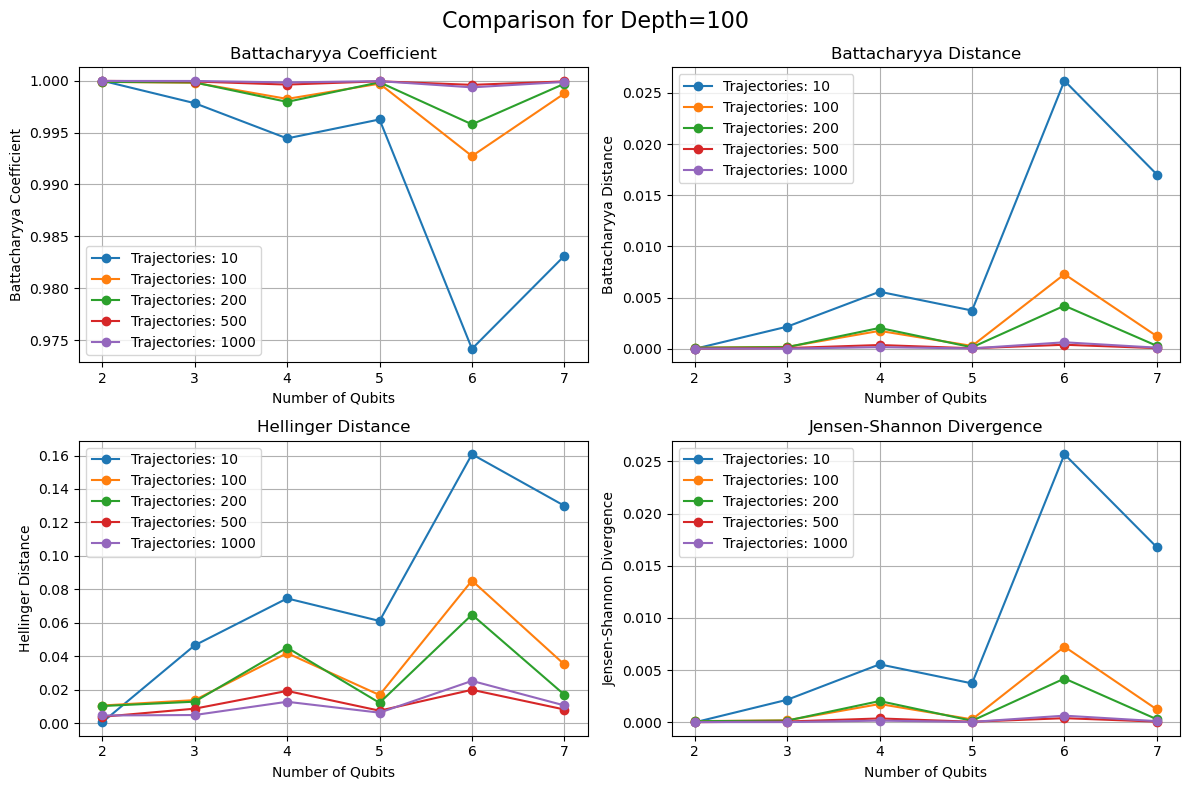

In [9]:
experiment_output = run_experiment(sim_backend="qiskit")
plot_metrics(list(experiment_output), [10, 100, 200, 500, 1000])

### Backend - Pennylane

Successfully switched backend to pennylane.


2026-02-17 18:07:47,353	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:08:18,065 E 696070 730346] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to pennylane.


2026-02-17 18:09:45,478	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:10:16,060 E 696070 734735] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to pennylane.


2026-02-17 18:13:05,821	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:13:36,453 E 696070 739969] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to pennylane.


2026-02-17 18:17:36,579	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:18:07,139 E 696070 746057] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to pennylane.


2026-02-17 18:23:52,705	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:24:23,308 E 696070 752559] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to pennylane.


2026-02-17 18:32:06,127	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:32:36,748 E 696070 760705] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


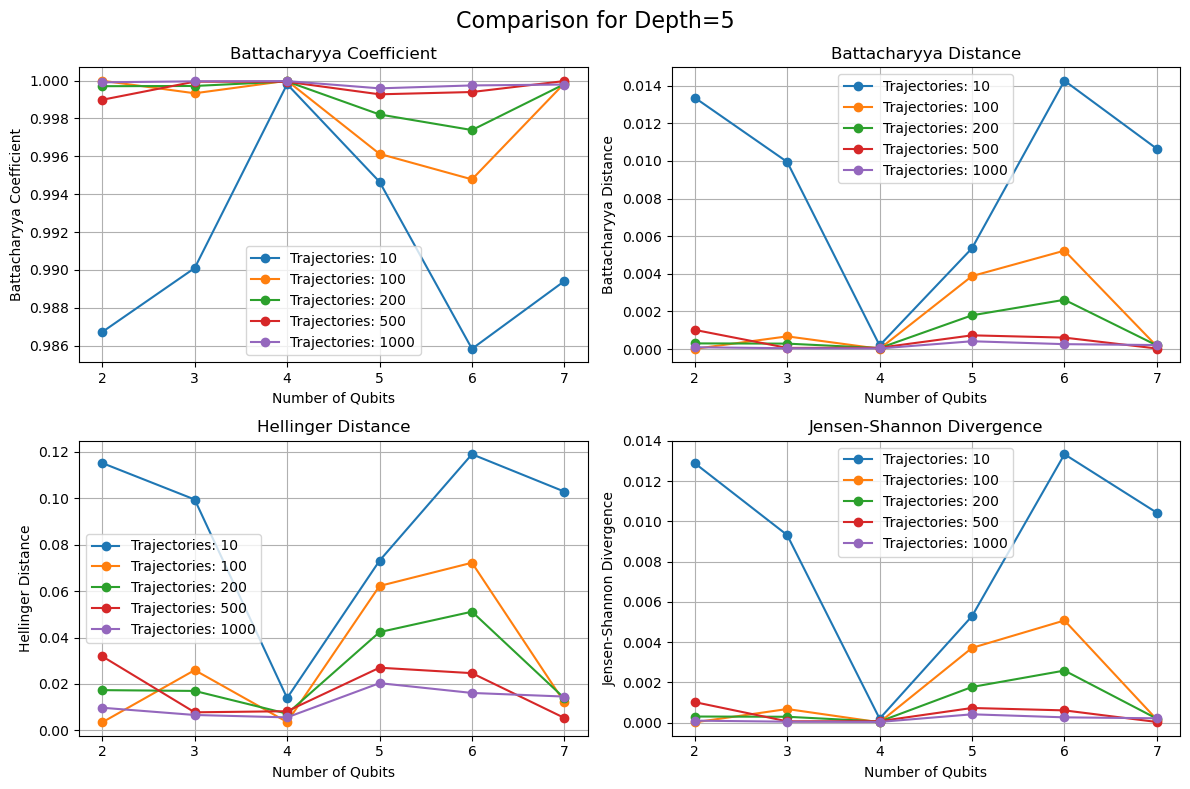

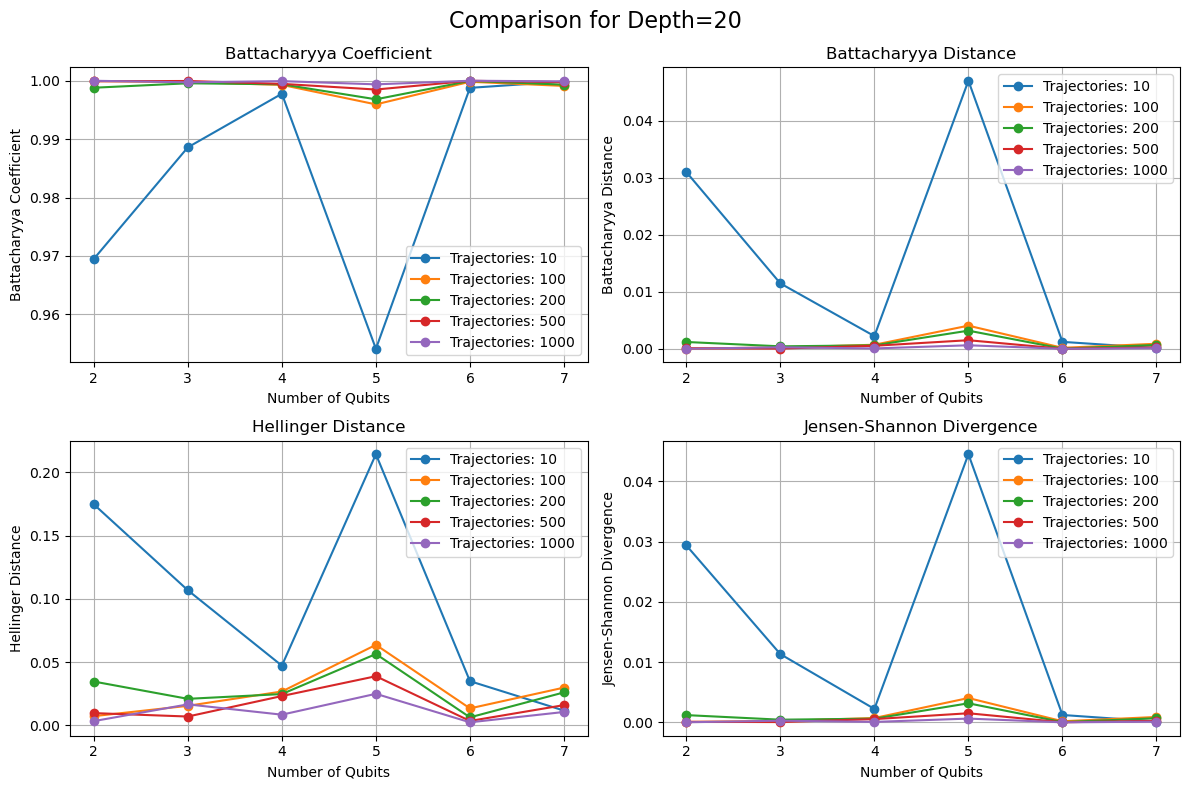

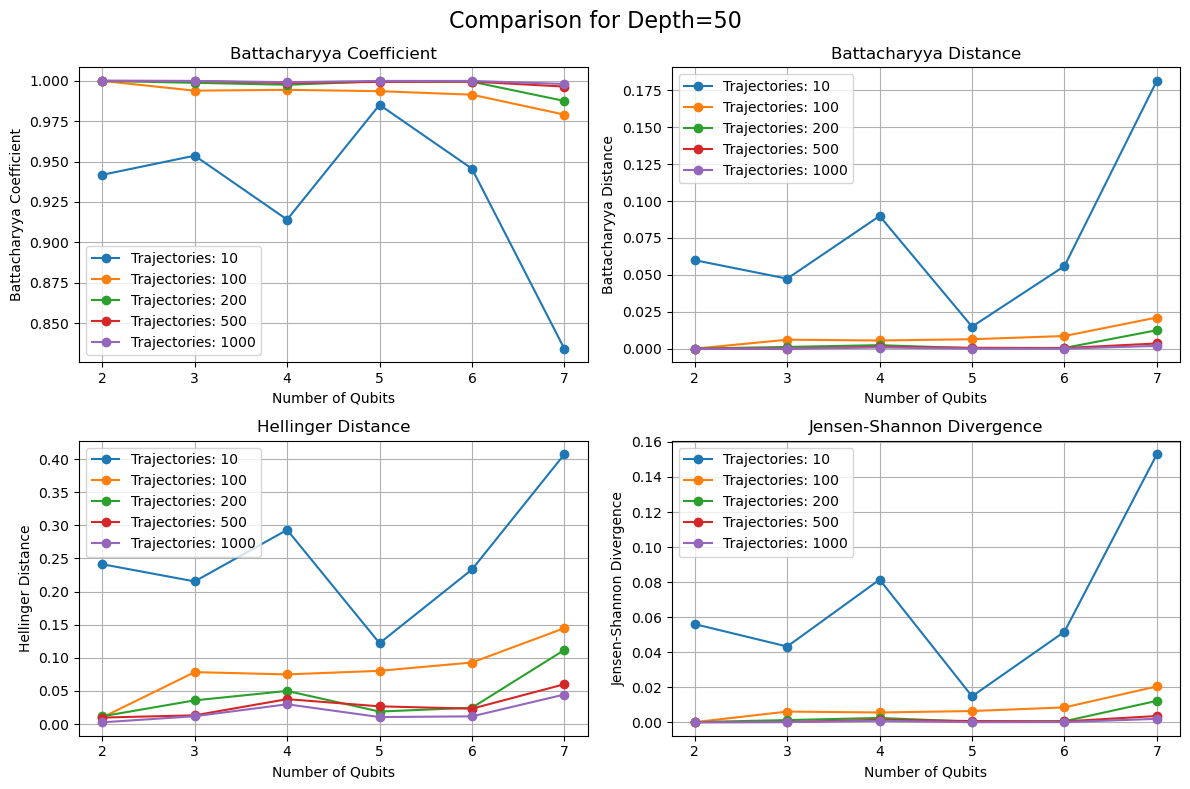

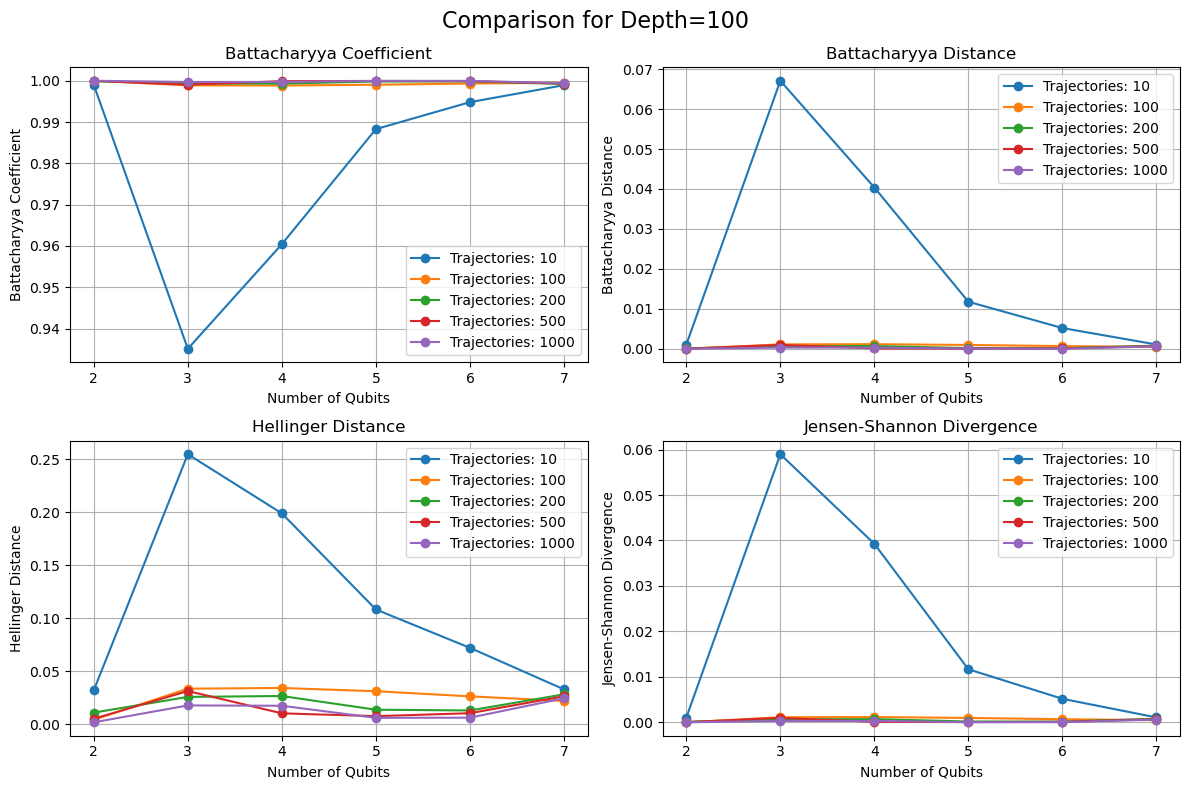

In [11]:
experiment_output = run_experiment(sim_backend="pennylane")
plot_metrics(list(experiment_output), [10, 100, 200, 500, 1000])

### Backend - Qulacs

Successfully switched backend to qulacs.


2026-02-17 18:45:48,046	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:46:18,668 E 696070 770060] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qulacs.


2026-02-17 18:47:16,375	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:47:47,005 E 696070 773885] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qulacs.


2026-02-17 18:49:48,805	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:50:19,422 E 696070 778137] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qulacs.


2026-02-17 18:53:11,624	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:53:42,261 E 696070 782634] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qulacs.


2026-02-17 18:57:29,724	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 18:58:00,339 E 696070 787410] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Successfully switched backend to qulacs.


2026-02-17 19:02:31,850	INFO worker.py:2007 -- Started a local Ray instance.
[2026-02-17 19:03:02,505 E 696070 792348] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


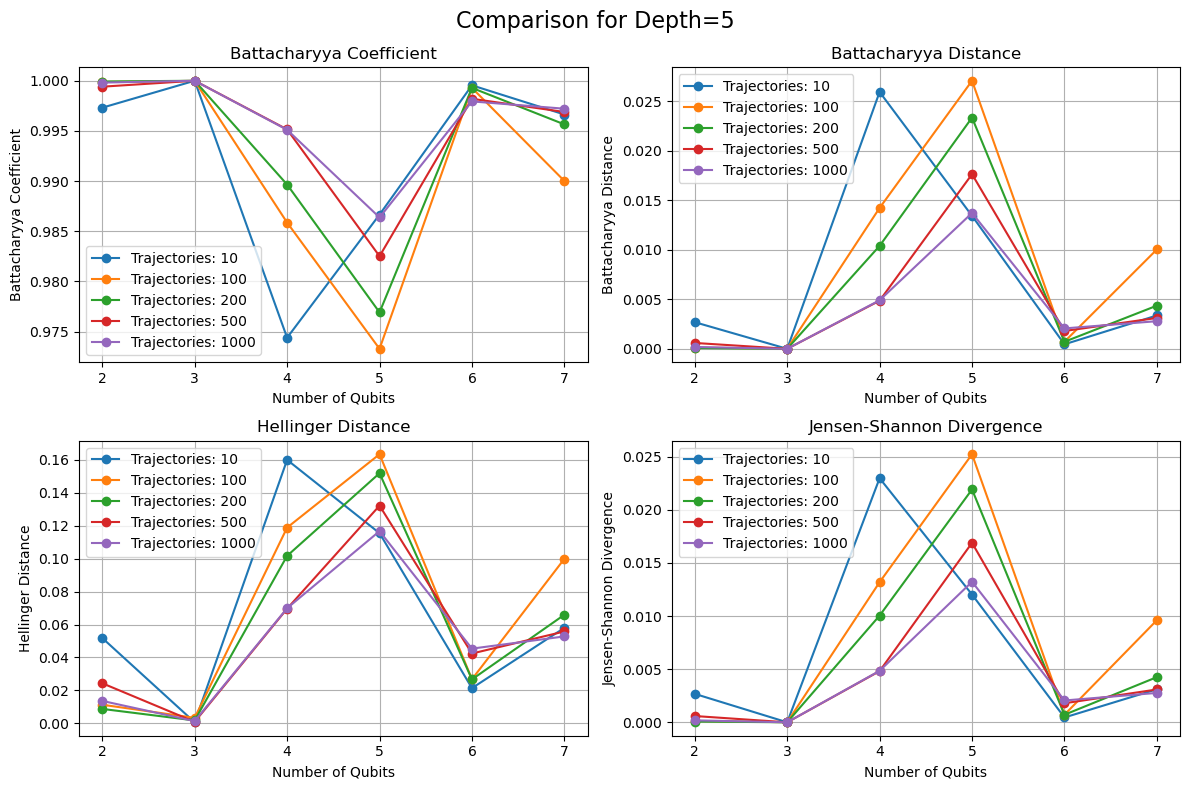

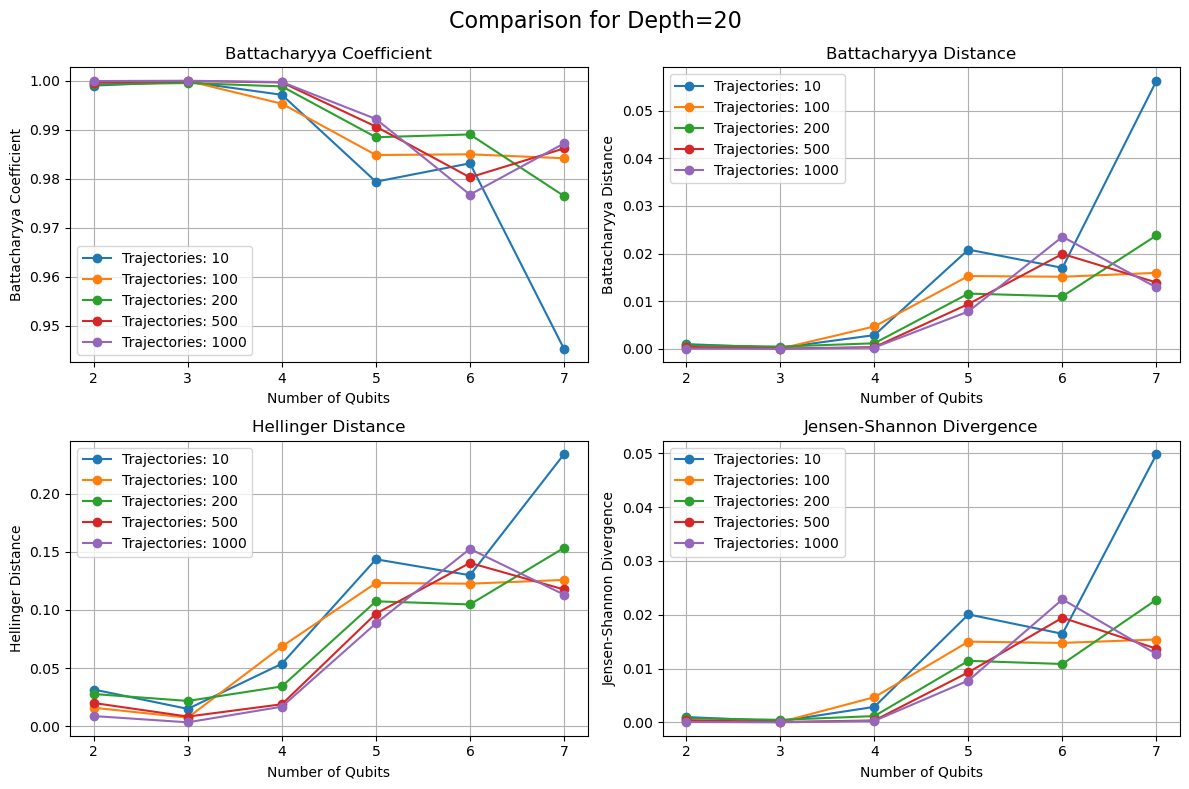

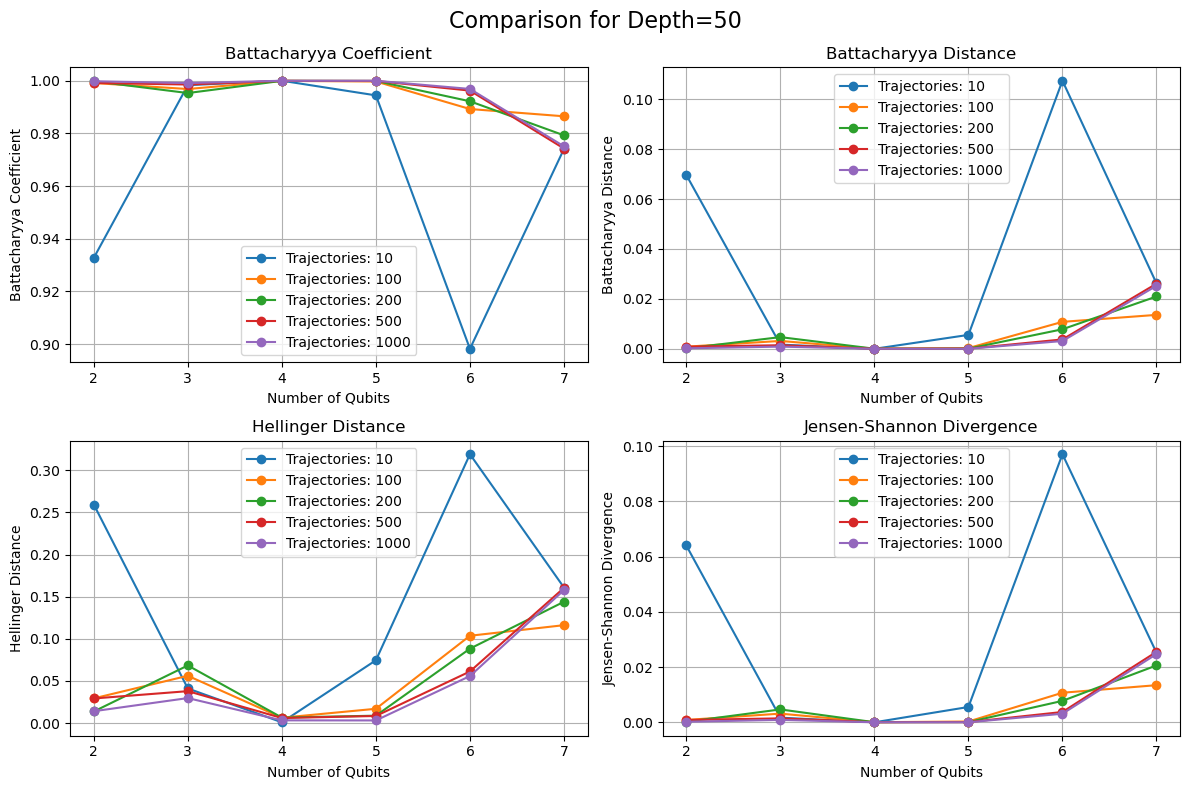

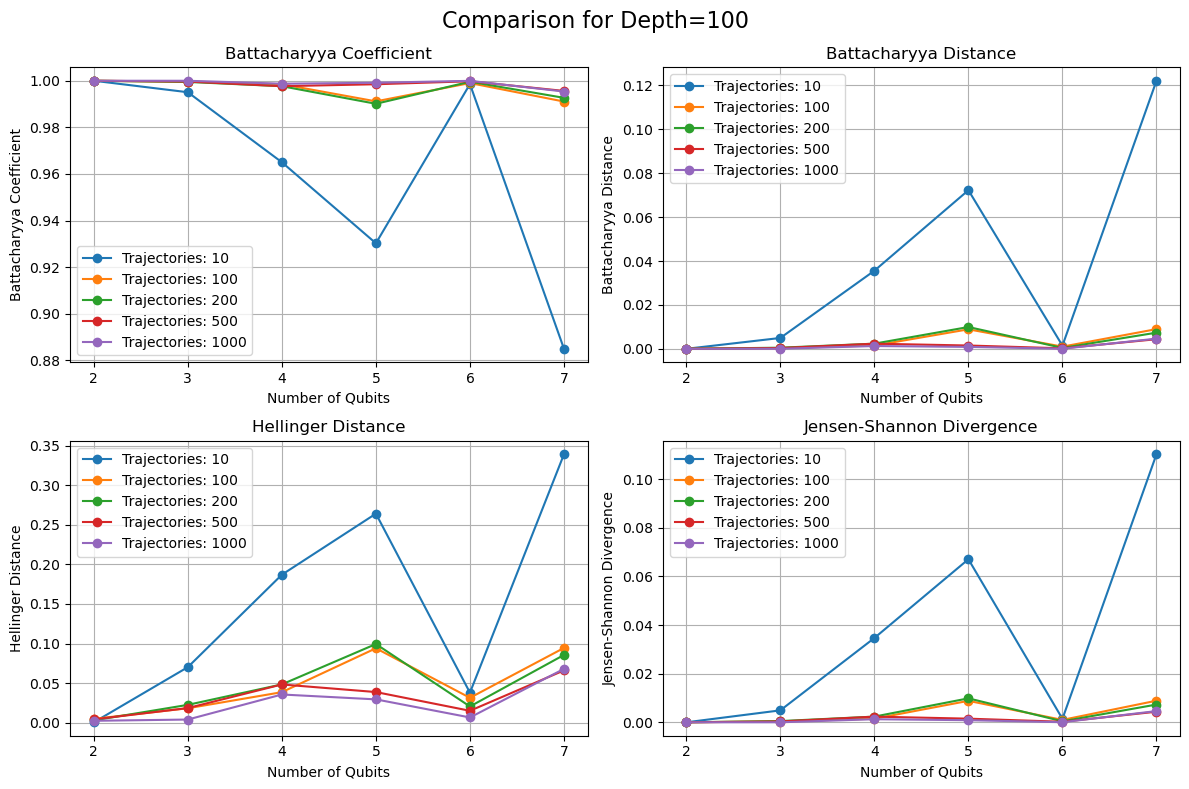

In [12]:
experiment_output = run_experiment(sim_backend="qulacs")
plot_metrics(list(experiment_output), [10, 100, 200, 500, 1000])